# 自己符号化器による非線型次元削減を自動微分ライブラリ（PyTorch）を用いて実装した例

* **このノートブックはGPUを有効にしておかないと実行に非常に時間がかかるので注意**
* GPUはColabの画面上にあるメニューの [ランタイム] -> [ランタイムのタイプを変更] から設定可能

## モジュールのインストール
Google Colabに標準でインストールされていないモジュールを最初にインストールしておく

In [1]:
!pip install torchviz
!pip install japanize-matplotlib

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=a7407e563922ff069ddf92df7c85ddf16606e226d0d2f050286dd9a58b535f4e
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=644ef18c4a2cebb4230f0aeb9a9fd16d95648677bbb6607d323b67f635ab4a1a
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


## 必要なモジュールの読み込み

* 可視化用のモジュール (Matplotlib) と自動微分の計算用モジュール (PyTorch)
* GPUが利用可能か判定し，可能な場合は利用するデバイスの種類をGPUに切り替える

In [2]:
from collections import OrderedDict

from tqdm import tqdm
from matplotlib import pyplot as plt
import japanize_matplotlib

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F


print('PyTorch version: ' + torch.__version__)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Device: ' + str(device))

PyTorch version: 2.1.0+cu121
Device: cuda


## データの準備とプロット

Pythonの機械学習用ライブラリである scikit-learn の中に準備されている Olivetti Faces データセット ($N = 400$) を用いる．

* The Database of Faces
    * https://cam-orl.co.uk/facedatabase.html
* 7.2.1. The Olivetti faces dataset | 7.2. Real world datasets — scikit-learn 1.3.2 documentation
    * https://scikit-learn.org/stable/datasets/real_world.html#the-olivetti-faces-dataset

In [3]:
from sklearn.datasets import fetch_olivetti_faces

faces, id_ = fetch_olivetti_faces(return_X_y=True)
n_data, n_features = faces.shape

print('#data: ' + str(n_data))
print('#features: ' + str(n_features))

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
#data: 400
#features: 4096


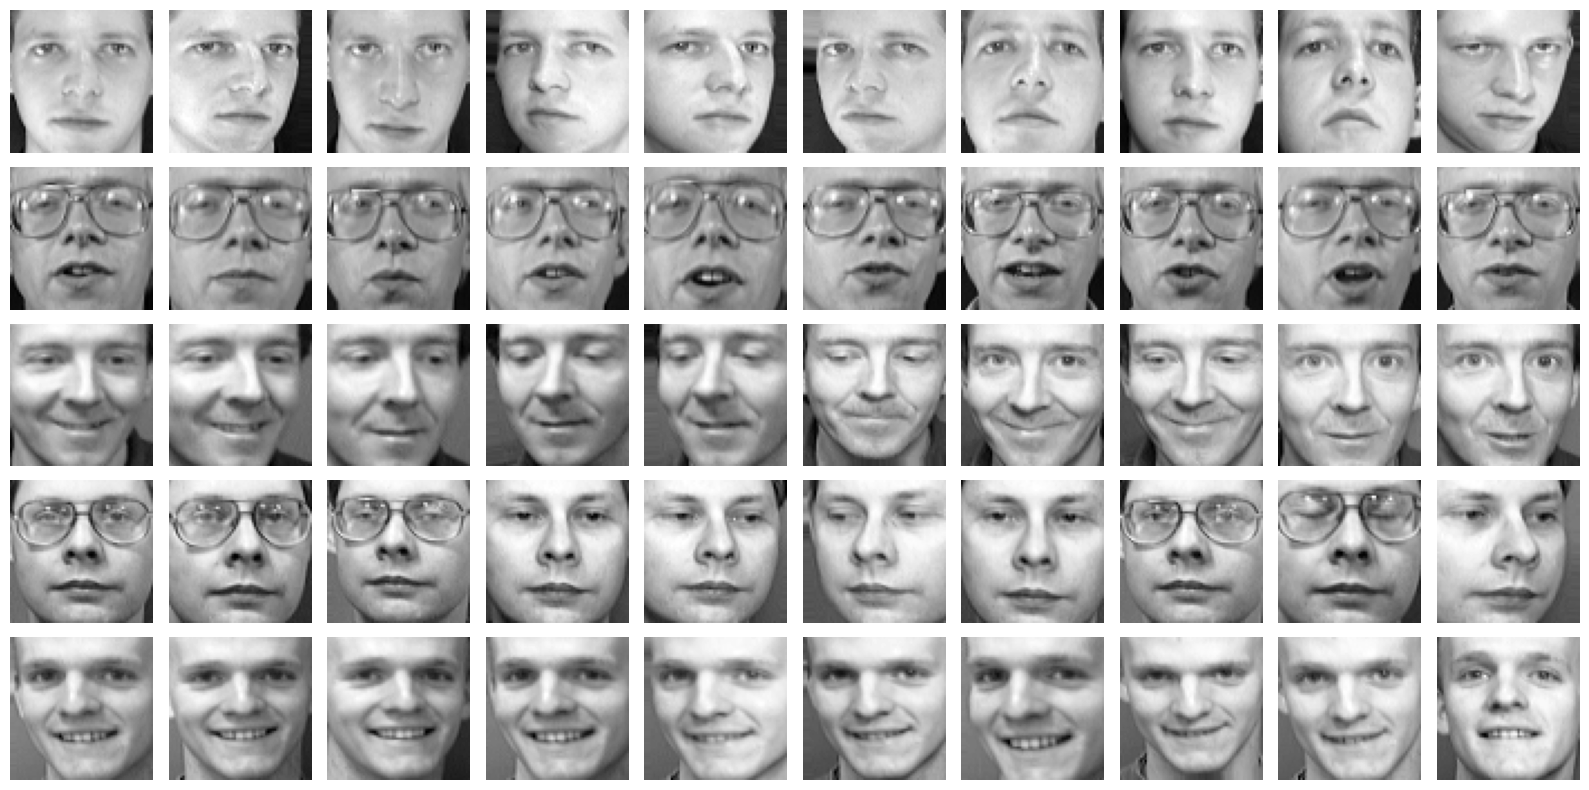

In [4]:
n_rows = 5
n_cols = 10

plt.figure(figsize=(16, 8))
for k in range(n_rows * n_cols):
    face = faces[k, :].reshape(64, 64)
    plt.subplot(n_rows, n_cols, k + 1)
    plt.imshow(face, cmap='gray')
    plt.axis('off')
plt.tight_layout()

## データの標準化

データセットの平均 $\mu$ と標準偏差 $\sigma$ を計算し，各データについて変換：

$$
z = \frac{x - \mu}{\sigma}
$$

をかけることでデータを標準化する (平均がゼロベクトル，共分散行列が単位行列)

In [5]:
faces_mean = faces.mean(axis=0)
faces_std = faces.std(axis=0)

In [6]:
# 平均を引いて標準偏差で割ることで標準化しておく
faces_standard = (faces - faces_mean) / faces_std

# PyTorchで処理するためにtensor型に変換
X = torch.from_numpy(faces_standard)

## モデルとデータ間の損失関数 (2乗誤差) の計算グラフを描画

データセット中の各画像は$64 \times 64 = 4096$ 個の画素を持っており，これらの画素値を一列に並べたものを4096次元のベクトルと見なしてモデルに入力する．

また，線型回帰の場合と異なり，パラメタのテンソル変数を用意するのではなく，
線型変換を行うモジュール `nn.Linear` とそれを積み重ねるモジュール `nn.Sequential` によってモデル全体を構築している．

* データ： $\{(\mathbf x_n)\}_{n=1}^N$
* モデル: $\mathbf x' = \mathbf W_2 \mathrm{ReLU}(\mathbf W_1 \mathbf x + \mathbf b_1) + \mathbf b_2$
* 損失関数：
$$
\begin{align*}
L(\mathbf W_1, \mathbf b_1, \mathbf W_2, \mathbf b_2) &= \sum_{n=1}^N \|\mathbf x - \mathbf x'\|^2
\end{align*}
$$

このモデルでは4096次元のデータを行列演算で一度256次元に落としてReLUを適用した後，もう一度4096次元に戻すという変換をしている．損失関数はその変換前後のベクトルの二乗誤差をとることで，モデルの出力が元々の入力をうまく復元できているかどうかを評価する．

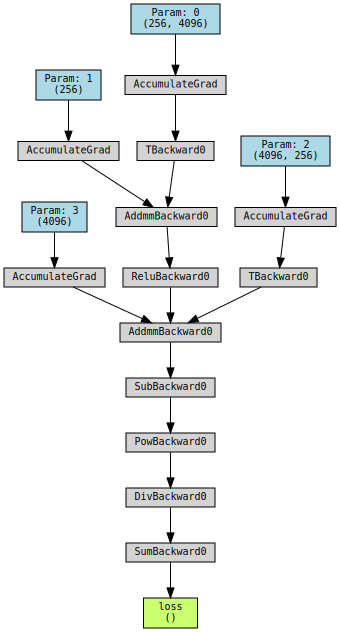

In [7]:
from torchviz import make_dot

model = nn.Sequential(OrderedDict(
    encoder=nn.Sequential(nn.Linear(4096, 256), nn.ReLU()),
    decoder=nn.Linear(256, 4096)
))

X_pred = model(X)
loss = torch.sum((X_pred - X) ** 2 / n_data)

# 計算グラフの生成
params = dict(
    ('Param: ' + str(k), param) for k, param in enumerate(model.parameters())
)
params.update({'loss': loss})
dot = make_dot(loss, params=params)

# 計算グラフの図をファイルに保存
dot.render('comp_graph', format='png')
dot.render('comp_graph', format='svg')

dot

## 勾配降下法による学習（損失関数を最小にする $\mathbf W_1, \mathbf b_1, \mathbf W_2, \mathbf b_2$ を探す）

線型回帰の場合とプログラムの構造は大きくは変わらない．細かな違いとして，ノートブック冒頭でデバイスがCPUかGPUかの情報を格納した変数 `device` を使ってデータとモデルを扱うデバイスを切り替える処理が増えている．

In [8]:
# パラメタの初期値を設定（requires_gradは勾配を計算する必要がある変数，つまりパラメタであることを意味する）
model = nn.Sequential(OrderedDict(
    encoder=nn.Sequential(nn.Linear(4096, 256), nn.ReLU()),
    decoder=nn.Linear(256, 4096)
))

# モデルとデータセットを扱うデバイスを変更する
# (ColabでGPUを有効にしていたらここでGPUが設定される．そうでない場合はCPUのままになる．)
X = X.to(device)
model = model.to(device)

losses = []

# 勾配降下法の実行
for k in tqdm(range(50000)):

    X_pred = model(X)
    loss = torch.sum((X_pred - X) ** 2 / n_data)

    assert not torch.isnan(loss.detach())

    # 計算グラフを loss ノードからモデルの各種パラメタのノードに向かって逆に辿ることで微分値を計算
    model.zero_grad()
    loss.backward()

    # 自動微分によって計算した微分値でパラメタの値を更新する
    # (ここでは計算グラフを作らないようにするため with torch.no_grad() の中で行う)
    with torch.no_grad():
        for param in model.parameters():
            # 学習率を動的に変更する
            if k < 40000:
                lr = 1e-4
            else:
                lr = 1e-6
            param -= lr * param.grad

    losses.append(loss.item())

100%|██████████| 50000/50000 [01:52<00:00, 443.45it/s]


Text(0, 0.5, 'loss')

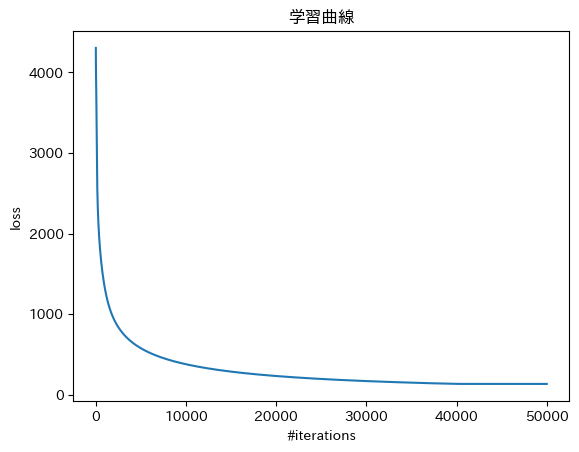

In [9]:
plt.plot(losses)
plt.title('学習曲線')
plt.xlabel('#iterations')
plt.ylabel('loss')

## 学習したパラメタを使った自己符号化器による画像再構成結果

出力結果の一行目が元画像，二行目が再構成された画像（一度256次元まで落としてから4096次元に戻された画像）．

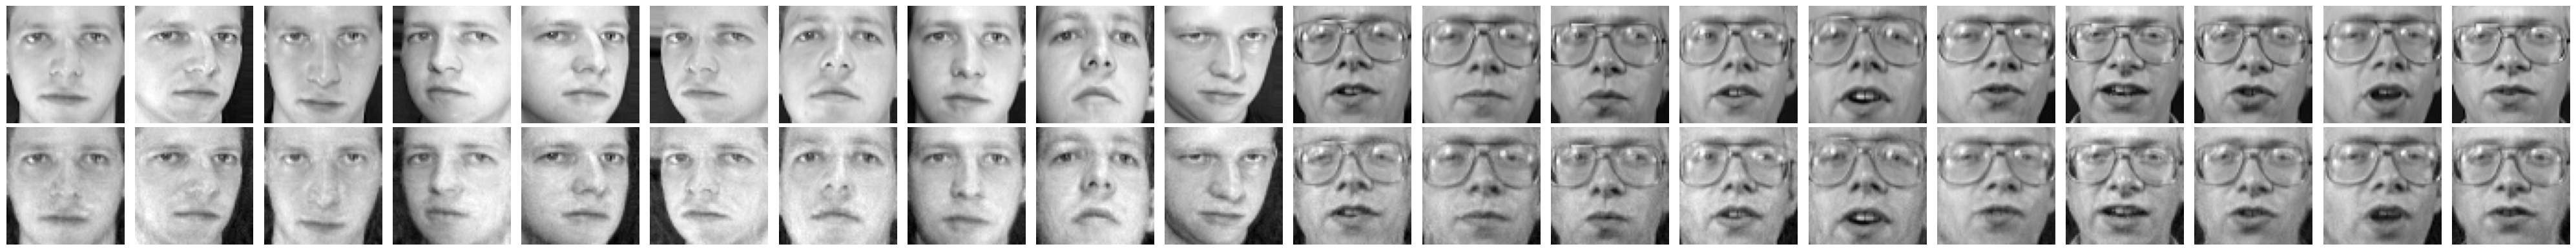

In [10]:
with torch.no_grad():
    X_pred = model(X)
    X_pred = X_pred.detach().cpu().numpy()

n_cols = 20

plt.figure(figsize=(40, 4))
for k in range(n_cols):
    face = faces[k, :].reshape(64, 64)
    x = X_pred[k, :].reshape(64, 64)
    x = faces_std.reshape(64, 64) * x + faces_mean.reshape(64, 64)
    plt.subplot(2, n_cols, k + 1)
    plt.imshow(face, cmap='gray')
    plt.axis('off')
    plt.subplot(2, n_cols, n_cols + k + 1)
    plt.imshow(x, cmap='gray')
    plt.axis('off')
plt.tight_layout()

## 学習したパラメタを使った自己符号化器のエンコーダによる圧縮結果

出力結果の一行目が元画像，二行目が圧縮された画像（256次元まで落とされたベクトル）．

In [11]:
import copy


# モデルからエンコーダだけを取り出す
encoder = copy.deepcopy(model.encoder)

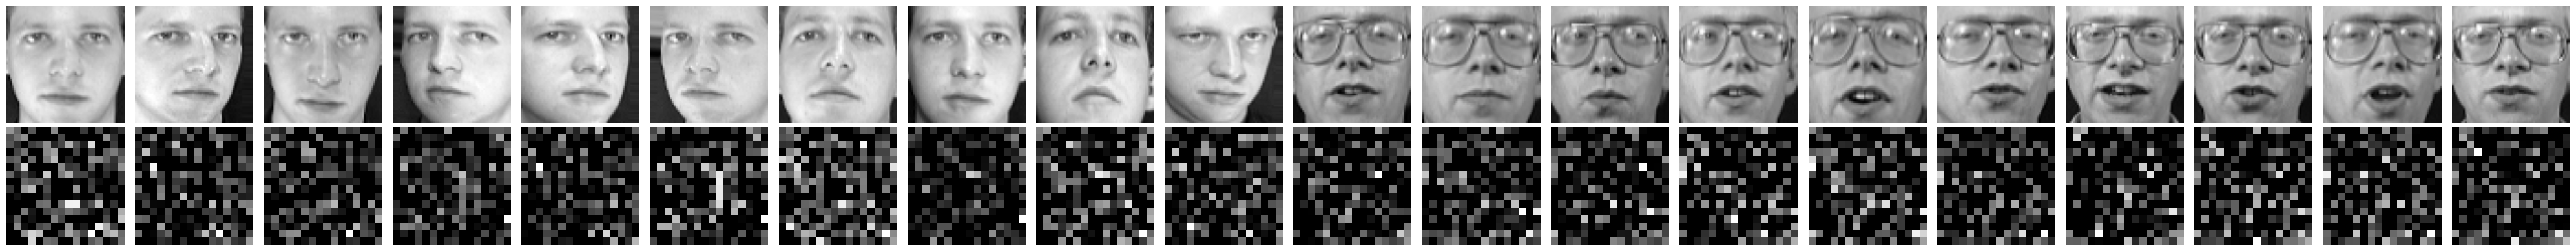

In [12]:
with torch.no_grad():
    X_pred = encoder(X)
    X_pred = X_pred.detach().cpu().numpy()

n_cols = 20

plt.figure(figsize=(40, 4))
for k in range(n_cols):
    face = faces[k, :].reshape(64, 64)
    x = X_pred[k, :].reshape(16, 16)
    plt.subplot(2, n_cols, k + 1)
    plt.imshow(face, cmap='gray')
    plt.axis('off')
    plt.subplot(2, n_cols, n_cols + k + 1)
    plt.imshow(x, cmap='gray')
    plt.axis('off')
plt.tight_layout()